<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/MobileSAM/MobileSAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Montaje y dependencias
from google.colab import drive
drive.mount('/content/drive')

import os, sys, json, time, math, warnings, pathlib, datetime, platform, shutil, random
warnings.filterwarnings("ignore")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from sklearn.metrics import jaccard_score, precision_score, recall_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Mounted at /content/drive
Device: cuda


In [ ]:
# Clonar e instalar MobileSAM
if not os.path.exists("/content/MobileSAM"):
    !git clone https://github.com/ChaoningZhang/MobileSAM.git
%cd /content/MobileSAM
!pip -q install -e /content/MobileSAM

# Asegurar import limpio
for d in ["/content/MobileSAM/__pycache__", "/content/MobileSAM/mobile_sam/__pycache__"]:
    shutil.rmtree(d, ignore_errors=True)

from mobile_sam import sam_model_registry

Cloning into 'MobileSAM'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1011 (delta 347), reused 261 (delta 260), pack-reused 604 (from 1)
Receiving objects: 100% (1011/1011), 95.44 MiB | 32.33 MiB/s, done.
Resolving deltas: 100% (461/461), done.
/content/MobileSAM
  Preparing metadata (setup.py) ... done


In [ ]:
#  Rutas y pesos
base_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI"
labeled_dir = os.path.join(base_dir, "Labeled")
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
vis_dir = "/content/resultados_pred"
os.makedirs(mask_output_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)

weights_path = "/content/MobileSAM/weights/mobile_sam.pt"
assert os.path.exists(weights_path), f"No se encuentra el checkpoint en {weights_path}"

# Cargar modelo
mobile_sam = sam_model_registry["vit_t"](checkpoint=weights_path).to(device)
mobile_sam.eval()
print("✅ MobileSAM cargado.")

✅ MobileSAM cargado.


In [ ]:

# 1) JSON (LabelMe) -> Máscaras binarias 0/255 (alineadas)

def scale_polygon(points, ann_w, ann_h, img_w, img_h):
    sx = img_w / float(ann_w) if ann_w else 1.0
    sy = img_h / float(ann_h) if ann_h else 1.0
    return [(x * sx, y * sy) for (x, y) in points]

def clamp_points(points, W, H):
    return [
        (int(max(0, min(W - 1, x))),
         int(max(0, min(H - 1, y))))
        for x, y in points
    ]

def build_image_and_mask_lists():
    image_paths, mask_paths = [], []
    json_files = sorted([f for f in os.listdir(labeled_dir) if f.lower().endswith(".json")])
    print("JSONs encontrados:", len(json_files))
    for jf in json_files:
        jp = os.path.join(labeled_dir, jf)
        try:
            data = json.load(open(jp, "r"))
        except Exception as e:
            print(f"⚠️ No se pudo leer {jp}: {e}")
            continue

        image_name = data.get("imagePath")
        if not image_name:
            continue

        ipath = os.path.join(labeled_dir, image_name)
        if not os.path.exists(ipath):
            print(f"⚠️ Falta imagen: {ipath}")
            continue

        img = Image.open(ipath).convert("RGB")
        W, H = img.size
        ann_w = data.get("imageWidth", W)
        ann_h = data.get("imageHeight", H)

        mask = Image.new("L", (W, H), 0)
        draw = ImageDraw.Draw(mask)

        polys = 0
        for shape in data.get("shapes", []):
            pts = shape.get("points", [])
            if not pts:
                continue
            # Si hay rectangles:
            if shape.get("shape_type") == "rectangle" and len(pts) == 2:
                (x1,y1),(x2,y2) = pts
                pts = [(x1,y1),(x2,y1),(x2,y2),(x1,y2)]
            scaled = clamp_points(scale_polygon(pts, ann_w, ann_h, W, H), W, H)
            if len(scaled) >= 3:
                draw.polygon(scaled, outline=255, fill=255)
                polys += 1

        if polys == 0:

            continue

        mname = os.path.splitext(image_name)[0] + "_mask.png"
        mpath = os.path.join(mask_output_dir, mname)
        mask.save(mpath)

        image_paths.append(ipath)
        mask_paths.append(mpath)

    print(f"✅ Máscaras generadas: {len(mask_paths)}")
    if image_paths:
        print("Ejemplo:\n  IMG:", image_paths[0], "\n  MSK:", mask_paths[0])
    return image_paths, mask_paths

image_paths, mask_paths = build_image_and_mask_lists()
assert len(image_paths) == len(mask_paths) and len(image_paths) > 0, "No hay pares válidos."

JSONs encontrados: 428
✅ Máscaras generadas: 428
Ejemplo:
  IMG: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/WIN_20220329_14_30_32_Pro.jpg 
  MSK: /content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/generated_masks/WIN_20220329_14_30_32_Pro_mask.png


In [ ]:

# 2) Preprocesado LETTERBOX centrado y normalización SAM

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 1024
# Normalización SAM (escala 0–255)
MEAN = [123.675, 116.28, 103.53]
STD  = [58.395, 57.12, 57.375]

sam_transform = T.Compose([
    T.ToTensor(),                 # [0,1]
    T.Lambda(lambda t: t*255.0),  # [0,255]
    T.Normalize(mean=MEAN, std=STD),
])

def preprocess_letterbox(image_pil, mask_pil, out_size=IMG_SIZE):
    """
    Imagen bilinear + máscara nearest con letterbox centrado a 1024.
    Normalización SAM en imagen. Devuelve:
      - img_tensor: (1,3,1024,1024) torch.float32 (ya en device)
      - mask_bin  : (1024,1024) uint8 en {0,1}
      - s, padx, pady, (Wp,Hp): parámetros de proyección
    """
    W, H = image_pil.size
    s = out_size / max(W, H)
    Wp, Hp = int(round(W * s)), int(round(H * s))

    # Letterbox imagen (bilinear)
    img_resized = image_pil.resize((Wp, Hp), resample=Image.BILINEAR)
    canvas_img = Image.new("RGB", (out_size, out_size), (0, 0, 0))
    padx = (out_size - Wp) // 2
    pady = (out_size - Hp) // 2
    canvas_img.paste(img_resized, (padx, pady))

    # Letterbox máscara (nearest) + binarización estricta
    mask_resized = mask_pil.resize((Wp, Hp), resample=Image.NEAREST)
    canvas_mask = Image.new("L", (out_size, out_size), 0)
    canvas_mask.paste(mask_resized, (padx, pady))
    mask_bin = (np.array(canvas_mask) > 127).astype(np.uint8)  # {0,1}

    # Normalización SAM
    img_tensor = sam_transform(canvas_img).unsqueeze(0).to(device)  # (1,3,1024,1024)

    return img_tensor, mask_bin, s, padx, pady, (Wp, Hp)

def project_points(points_xy, s, padx, pady):
    """Proyección (x,y) original -> (x',y') en lienzo letterbox 1024."""
    pts = np.asarray(points_xy, dtype=np.float32).copy()
    pts[:, 0] = pts[:, 0] * s + padx
    pts[:, 1] = pts[:, 1] * s + pady
    return pts


# 3) Helpers de métrica e inferencia

def dice_coef_np(y_true, y_pred):
    # y_true, y_pred: arrays binarios {0,1} del mismo tamaño
    y_true = (y_true > 0).astype(np.uint8)
    y_pred = (y_pred > 0).astype(np.uint8)
    inter = np.sum(y_true & y_pred)
    return 2.0 * inter / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

@torch.inference_mode()
def encode_image(mobile_sam, input_tensor):
    """Codificador de imagen MobileSAM (devuelve embeddings)."""
    return mobile_sam.image_encoder(input_tensor)

def decode_mask_best(
    mobile_sam,
    image_embedding,           # (1, C, 64, 64)
    sparse_embeddings,         # salidas del prompt_encoder
    dense_embeddings,          # salidas del prompt_encoder
    out_size=IMG_SIZE,
    thr=0.5,
    multimask=True
):
    """
    Decodifica máscaras, elige la mejor por IoU predicho y reescala a out_size.
    Devuelve máscara binaria numpy (H,W) en {0,1}.
    """
    with torch.no_grad():
        low_res_masks, iou_preds = mobile_sam.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=mobile_sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask,
        )
        # low_res_masks: (B,M,256,256) o (B,1,256,256)
        # iou_preds   : (B,M)

        # Selección de la mejor hipótesis por IoU predicho
        if low_res_masks.ndim == 4 and low_res_masks.shape[1] > 1:
            best_idx = torch.argmax(iou_preds, dim=1)              # (B,)
            b = torch.arange(low_res_masks.shape[0], device=low_res_masks.device)
            low_res_masks = low_res_masks[b, best_idx][:, None]    # (B,1,256,256)

        # Garantizar 4D (B,1,256,256)
        if low_res_masks.ndim == 3:
            low_res_masks = low_res_masks.unsqueeze(1)

        assert low_res_masks.ndim == 4 and low_res_masks.shape[-2:] == (256, 256), \
            f"Esperaba (B,1,256,256), obtuve {tuple(low_res_masks.shape)}"

        # Upscale a out_size x out_size (logits)
        up = F.interpolate(low_res_masks, size=(out_size, out_size),
                           mode="bilinear", align_corners=False)  # (B,1,H,W)

        # Binarización
        prob = up.sigmoid()
        mask_bin = (prob > thr).to(torch.uint8)                    # (B,1,H,W)
        return mask_bin[0, 0].cpu().numpy()                        # (H,W) {0,1}

def overlay_mask(img_rgb_uint8, mask_bin, alpha=0.45, color=(0, 0, 255)):
    """Superpone una máscara binaria {0,1} sobre una imagen RGB uint8."""
    img = img_rgb_uint8.copy()
    mask = (mask_bin > 0)
    overlay = img.copy()
    overlay[mask] = (overlay[mask] * (1 - alpha) + np.array(color) * alpha).astype(np.uint8)
    return overlay


# 4) Dataset RAW (devuelve PIL) y DataLoader

class PCBDefectDatasetRaw(Dataset):
    def __init__(self, image_paths, mask_paths):
        assert len(image_paths) == len(mask_paths), "Desajuste imagen/máscara"
        self.image_paths = image_paths
        self.mask_paths = mask_paths
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        msk = Image.open(self.mask_paths[idx]).convert("L")
        return img, msk, self.image_paths[idx]

eval_loader = DataLoader(
    PCBDefectDatasetRaw(image_paths, mask_paths),
    batch_size=1, shuffle=False, num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=lambda x: x
)




🚀 Evaluando MobileSAM (letterbox centrado) con 4 tipos de prompt...



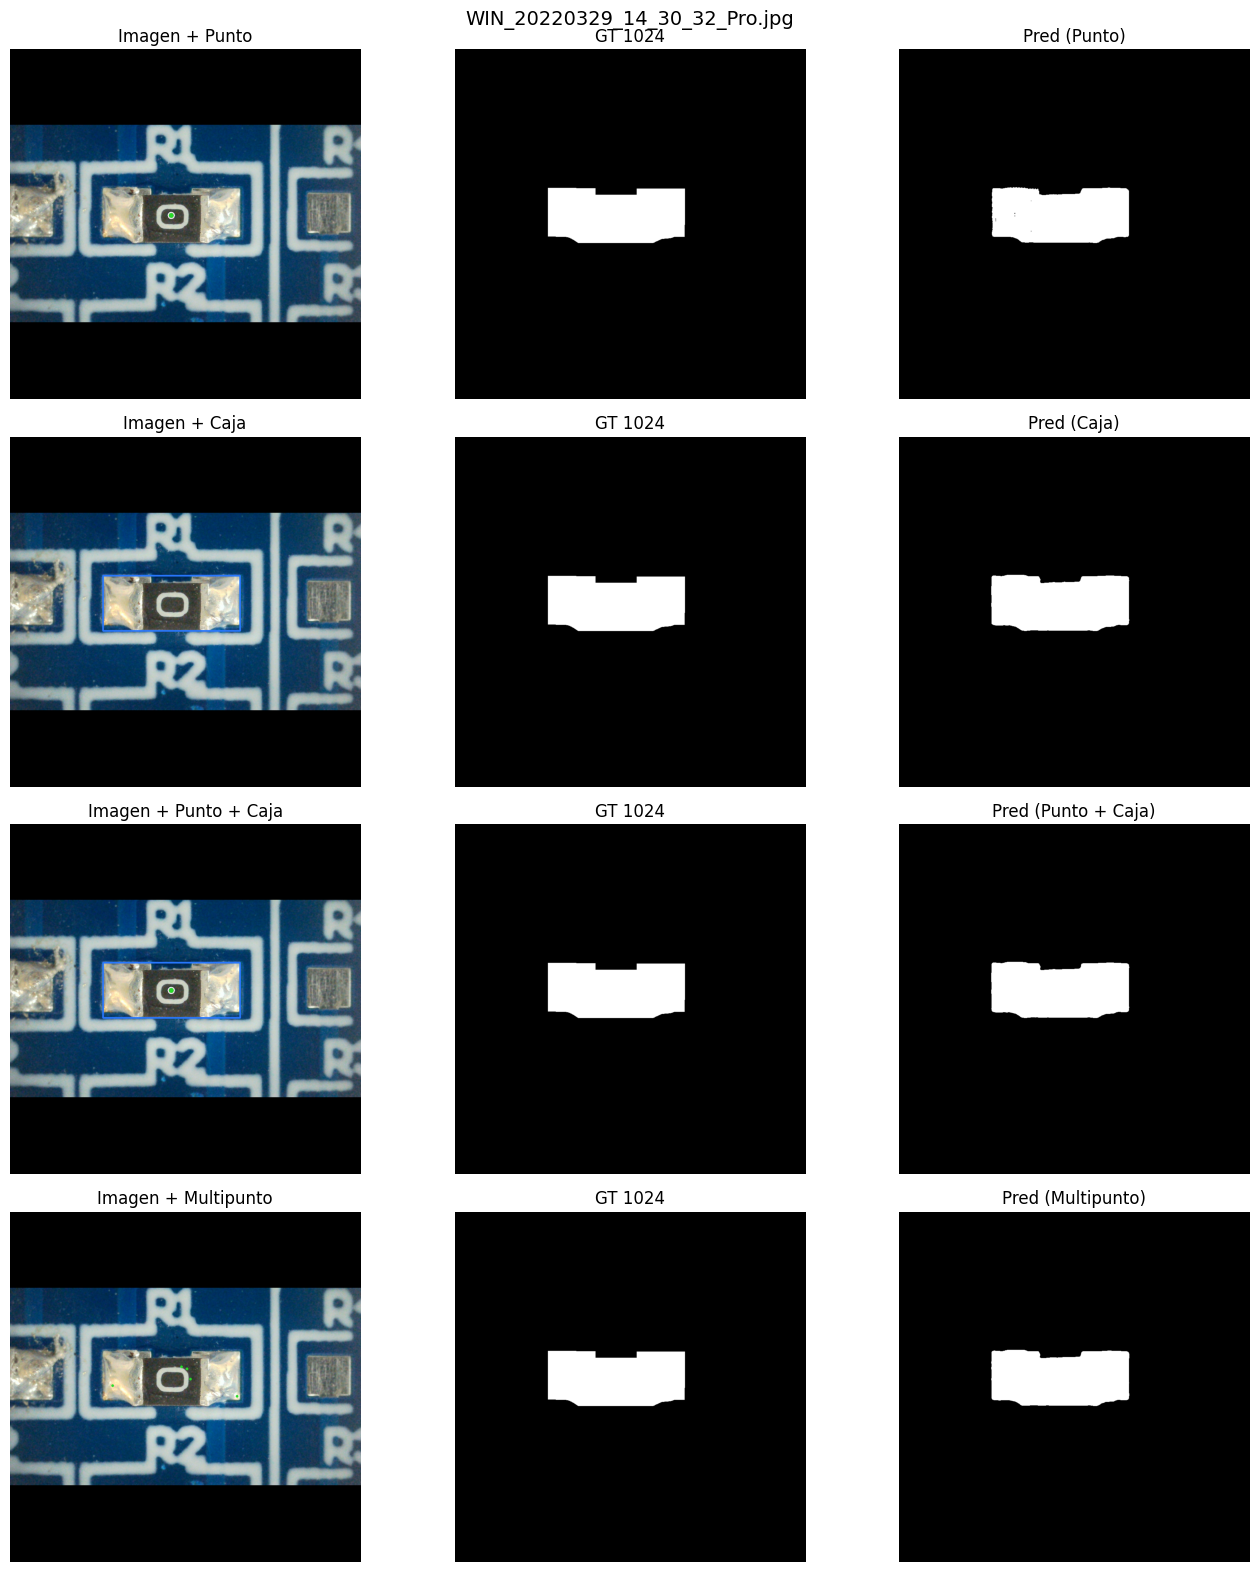

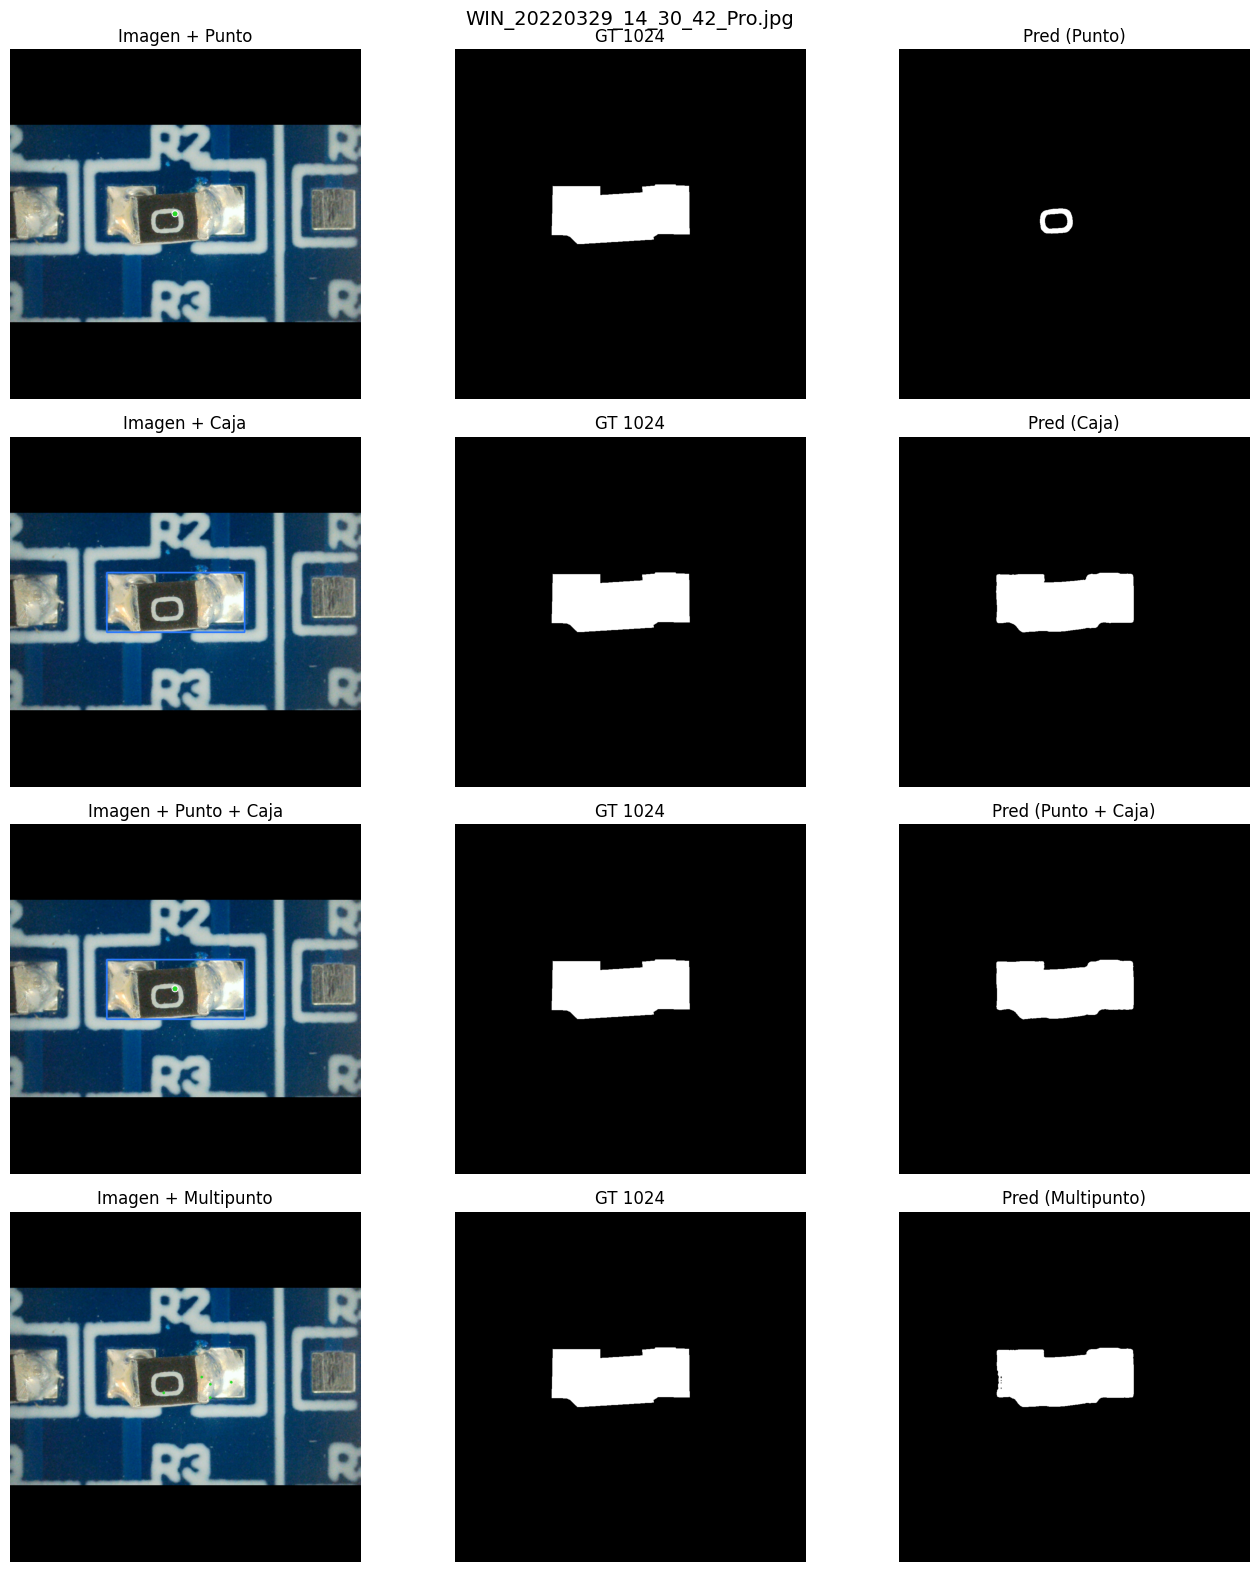

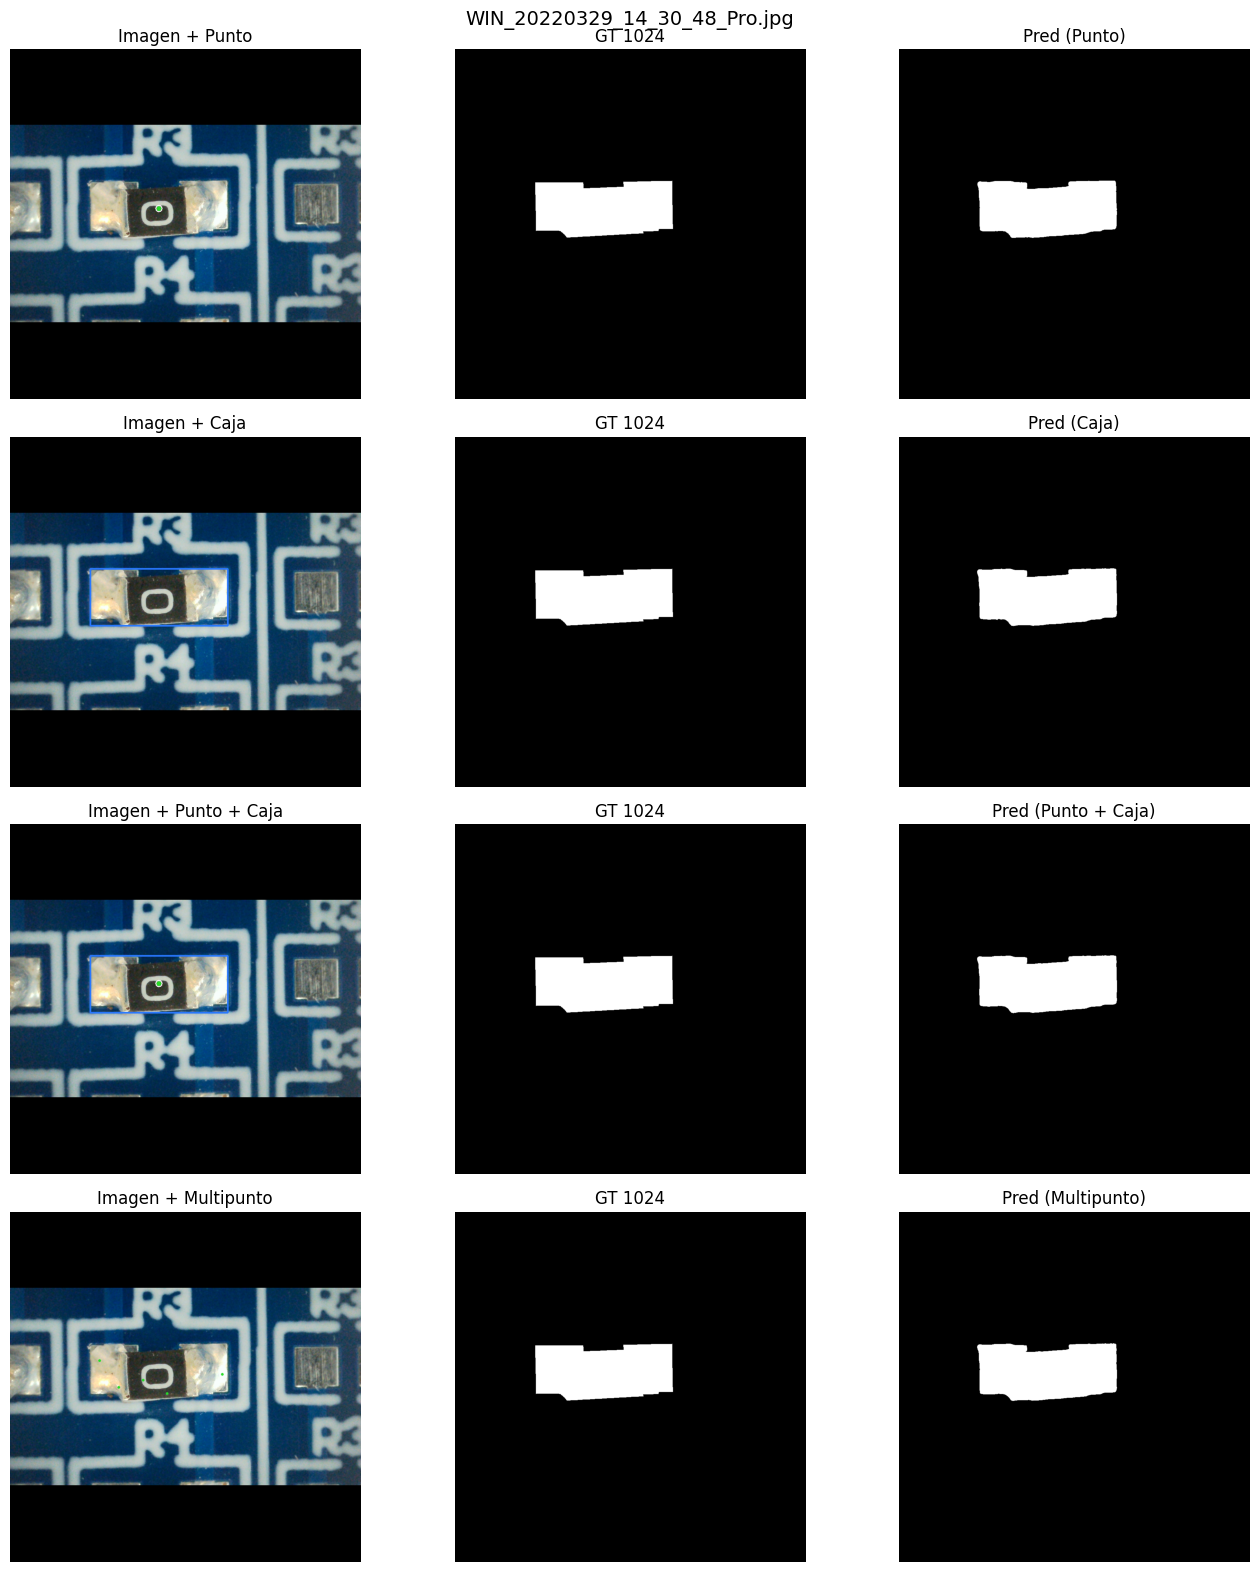

✅ Evaluación completada.

📊 MÉTRICAS PROMEDIO Y VARIABILIDAD:

— POINT
IoU: 0.2385 ± 0.3033
Dice: 0.3060 ± 0.3290
Precisión: 0.5562 ± 0.4376
Recall: 0.4487 ± 0.4531
⏱️ Tiempo promedio: 0.0678 s  | ⚡ FPS: 14.75
💾 VRAM promedio: 107.35 ± 0.36 MB

— BOX
IoU: 0.7259 ± 0.2625
Dice: 0.8124 ± 0.1899
Precisión: 0.7364 ± 0.2679
Recall: 0.9807 ± 0.0388
⏱️ Tiempo promedio: 0.0091 s  | ⚡ FPS: 110.02
💾 VRAM promedio: 107.35 ± 0.36 MB

— BOX+POINT
IoU: 0.7252 ± 0.2626
Dice: 0.8119 ± 0.1900
Precisión: 0.7361 ± 0.2691
Recall: 0.9817 ± 0.0332
⏱️ Tiempo promedio: 0.0103 s  | ⚡ FPS: 96.85
💾 VRAM promedio: 107.36 ± 0.36 MB

— MULTIPOINT
IoU: 0.6825 ± 0.2591
Dice: 0.7816 ± 0.1938
Precisión: 0.7308 ± 0.2703
Recall: 0.9399 ± 0.1312
⏱️ Tiempo promedio: 0.0104 s  | ⚡ FPS: 95.81
💾 VRAM promedio: 107.38 ± 0.36 MB

📁 CSV guardado en: /content/resultados_pred/mobilesam_letterbox_eval.csv
📝 Report guardado en: /content/resultados_pred/mobilesam_letterbox_report.json
🔖 LaTeX guardado en: /content/resultados_pred/mob

In [ ]:

# 5) Evaluación con 4 tipos de prompt

prompt_types = ["point", "box", "box+point", "multipoint"]
results = {k: {"ious": [], "dices": [], "precs": [], "recs": [], "times": [], "vrams": [], "last_pred": None}
           for k in prompt_types}

rng = np.random.default_rng(0)  # reproducibilidad multipoint

print("\n🚀 Evaluando MobileSAM (letterbox centrado) con 4 tipos de prompt...\n")

show_first_n = 3  # cuántas visualizaciones en pantalla
for i, batch in enumerate(eval_loader):
    image_pil, mask_pil, path = batch[0]
    gt_mask = (np.array(mask_pil) > 127)
    coords = np.argwhere(gt_mask)  # (y,x)
    if coords.size == 0:
        print(f"⚠️ Sin anotación en: {path}")
        continue

    # bbox + centro en espacio original
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    y_c, x_c = coords.mean(axis=0).astype(int)

    # Preprocesado  (imagen y GT) con letterbox centrado
    input_tensor, gt_1024, s, padx, pady, (Wp, Hp) = preprocess_letterbox(image_pil, mask_pil)
    image_embedding = encode_image(mobile_sam, input_tensor)
    y_true = gt_1024.flatten().astype(np.uint8)

    # Proyección de prompts al espacio 1024 letterbox
    pt_xy   = project_points(np.array([[x_c, y_c]], dtype=np.float32), s, padx, pady)
    box_xy  = project_points(np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32), s, padx, pady)

    # Multipoint: muestreo uniforme de 5 puntos dentro de GT, luego proyectar
    n_points = min(5, len(coords))
    sampled = coords[rng.choice(len(coords), size=n_points, replace=False)]
    mp_xy   = project_points(np.stack([sampled[:,1], sampled[:,0]], axis=1), s, padx, pady)

    # Tensores/labels (SAM espera lotes BxNx2 y labels BxN)
    def as_pt_lbl(xy, labels):
        pt = torch.tensor(xy, dtype=torch.float32, device=device)[None, :, :]
        lb = torch.tensor(labels, dtype=torch.int64, device=device)[None, :]
        return pt, lb

    # Evaluar cada método
    for method in prompt_types:
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)
        t0 = time.time()

        if method == "point":
            pt, lb = as_pt_lbl(pt_xy, [1])
            se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=None, masks=None)

        elif method == "box":
            # SAM usa boxes como (x0,y0,x1,y1), BxNx4
            box = torch.tensor([[box_xy[0,0], box_xy[0,1], box_xy[1,0], box_xy[1,1]]],
                               dtype=torch.float32, device=device)[None, :, :]
            se, de = mobile_sam.prompt_encoder(points=None, boxes=box, masks=None)

        elif method == "box+point":
            pt, lb = as_pt_lbl(pt_xy, [1])
            box = torch.tensor([[box_xy[0,0], box_xy[0,1], box_xy[1,0], box_xy[1,1]]],
                               dtype=torch.float32, device=device)[None, :, :]
            se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=box, masks=None)

        elif method == "multipoint":
            labels = np.ones(mp_xy.shape[0], dtype=np.int64)
            pt, lb = as_pt_lbl(mp_xy, labels)
            se, de = mobile_sam.prompt_encoder(points=(pt, lb), boxes=None, masks=None)

        pred_mask = decode_mask_best(mobile_sam, image_embedding, se, de, out_size=IMG_SIZE, thr=0.5)
        elapsed = time.time() - t0

        y_pred = pred_mask.flatten().astype(np.uint8)

        # Métricas
        results[method]["ious"].append(jaccard_score(y_true, y_pred, zero_division=0))
        results[method]["dices"].append(dice_coef_np(y_true, y_pred))
        results[method]["precs"].append(precision_score(y_true, y_pred, zero_division=0))
        results[method]["recs"].append(recall_score(y_true, y_pred, zero_division=0))
        results[method]["times"].append(elapsed)

        if torch.cuda.is_available():
            vram = torch.cuda.max_memory_allocated(device) / (1024**2)
            results[method]["vrams"].append(vram)

        # Guardar última pred para panel resumen
        results[method]["last_pred"] = pred_mask

    # Visualización de las primeras muestras
    if i < show_first_n:
        img_1024 = np.array(Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0)))
        # reconstruye imagen ya normalizada
        W, H = image_pil.size
        s2 = IMG_SIZE / max(W, H); Wp2, Hp2 = int(round(W*s2)), int(round(H*s2))
        img_resized = image_pil.resize((Wp2, Hp2), resample=Image.BILINEAR)
        canvas_img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
        padx2 = (IMG_SIZE - Wp2) // 2; pady2 = (IMG_SIZE - Hp2) // 2
        canvas_img.paste(img_resized, (padx2, pady2))
        img_1024 = np.array(canvas_img, dtype=np.uint8)

        order = [("Punto", "point"), ("Caja", "box"), ("Punto + Caja", "box+point"), ("Multipunto", "multipoint")]
        fig, axs = plt.subplots(4, 3, figsize=(14, 16))
        for r, (title, key) in enumerate(order):
            # Dibujar prompts
            prom = img_1024.copy()
            if key == "point":
                x,y = project_points(np.array([[x_c, y_c]], dtype=np.float32), s2, padx2, pady2)[0]
                x,y = int(round(x)), int(round(y))
                import cv2
                cv2.circle(prom, (x,y), 7, (40,220,40), -1)
                cv2.circle(prom, (x,y), 9, (255,255,255), 2)
            elif key == "box":
                import cv2
                b = project_points(np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32), s2, padx2, pady2)
                x0,y0 = map(int, map(round, b[0])); x1,y1 = map(int, map(round, b[1]))
                cv2.rectangle(prom, (x0,y0), (x1,y1), (40,120,255), 3)
            elif key == "box+point":
                import cv2
                b = project_points(np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32), s2, padx2, pady2)
                x0,y0 = map(int, map(round, b[0])); x1,y1 = map(int, map(round, b[1]))
                cv2.rectangle(prom, (x0,y0), (x1,y1), (40,120,255), 3)
                x,y = project_points(np.array([[x_c, y_c]], dtype=np.float32), s2, padx2, pady2)[0]
                x,y = int(round(x)), int(round(y))
                cv2.circle(prom, (x,y), 7, (40,220,40), -1)
                cv2.circle(prom, (x,y), 9, (255,255,255), 2)
            else: # multipoint
                import cv2
                pts = project_points(np.stack([sampled[:,1], sampled[:,0]], axis=1), s2, padx2, pady2)
                for (xx,yy) in pts:
                    cv2.circle(prom, (int(round(xx)),int(round(yy))), 4, (40,220,40), -1)
            axs[r,0].imshow(prom); axs[r,0].set_title(f"Imagen + {title}"); axs[r,0].axis("off")

            axs[r,1].imshow(gt_1024, cmap='gray', vmin=0, vmax=1); axs[r,1].set_title("GT 1024"); axs[r,1].axis("off")
            axs[r,2].imshow(results[key]["last_pred"], cmap='gray', vmin=0, vmax=1); axs[r,2].set_title(f"Pred ({title})"); axs[r,2].axis("off")

        fig.suptitle(os.path.basename(path), fontsize=14)
        plt.tight_layout()
        plt.show()

print("✅ Evaluación completada.")


# 6) Resumen y export (CSV + JSON)

import pandas as pd

rows = []
print("\n📊 MÉTRICAS PROMEDIO Y VARIABILIDAD:")
for method in prompt_types:
    iou  = np.array(results[method]['ious'])
    dice = np.array(results[method]['dices'])
    prec = np.array(results[method]['precs'])
    rec  = np.array(results[method]['recs'])
    t    = np.array(results[method]['times'])
    vram = np.array(results[method]['vrams']) if len(results[method]['vrams']) else np.array([])

    miou, siou   = iou.mean(),  iou.std()
    mdice, sdice = dice.mean(), dice.std()
    mpre,  spre  = prec.mean(), prec.std()
    mrec,  srec  = rec.mean(),  rec.std()
    mtime        = t.mean()

    print(f"\n— {method.upper()}")
    print(f"IoU: {miou:.4f} ± {siou:.4f}")
    print(f"Dice: {mdice:.4f} ± {sdice:.4f}")
    print(f"Precisión: {mpre:.4f} ± {spre:.4f}")
    print(f"Recall: {mrec:.4f} ± {srec:.4f}")
    print(f"⏱️ Tiempo promedio: {mtime:.4f} s  | ⚡ FPS: {1.0/max(mtime,1e-9):.2f}")
    if vram.size:
        print(f"💾 VRAM promedio: {vram.mean():.2f} ± {vram.std():.2f} MB")

    rows.append({
        "Modelo": "MobileSAM (vit_t)",
        "Modo": method,
        "IoU_mean": miou, "IoU_std": siou,
        "Dice_mean": mdice, "Dice_std": sdice,
        "Prec_mean": mpre, "Prec_std": spre,
        "Rec_mean": mrec, "Rec_std": srec,
        "Time_mean_s": mtime,
        "FPS": (1.0/mtime if mtime>0 else float("inf")),
        "VRAM_MB_mean": float(vram.mean()) if vram.size else None,
        "VRAM_MB_std": float(vram.std()) if vram.size else None,
    })

df = pd.DataFrame(rows)
csv_path = os.path.join(vis_dir, "mobilesam_letterbox_eval.csv")
df.to_csv(csv_path, index=False)
print("\n📁 CSV guardado en:", csv_path)

# Informe JSON del proceso
report = {
    "model": "MobileSAM vit_t",
    "device": str(device),
    "n_images": len(image_paths),
    "img_preprocess": {
        "letterbox": True, "out_size": IMG_SIZE,
        "image_resize": "BILINEAR", "mask_resize": "NEAREST",
        "normalization": {"scale": "[0,1]->*255", "mean": MEAN, "std": STD}
    },
    "prompts": {
        "point": "centroide GT",
        "box": "bbox min/max GT",
        "box+point": "bbox + centroide",
        "multipoint": "5 puntos muestreados en GT (semilla=0)",
        "projection": "x'=x*s+padx, y'=y*s+pady (letterbox)"
    },
    "threshold": 0.5,
    "metrics": ["IoU (jaccard)", "Dice", "Precision", "Recall"],
    "timing": True,
    "vram_peak": "torch.cuda.max_memory_allocated",
    "timestamp": datetime.datetime.now().isoformat()
}
json_path = os.path.join(vis_dir, "mobilesam_letterbox_report.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print("📝 Report guardado en:", json_path)
